In [32]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

Loading the data:

In [33]:
train_data = np.load("./logisticRegression_data/train_data.npy")
train_labels = np.load("./logisticRegression_data/train_labels.npy")

test_data = np.load("./logisticRegression_data/test_data.npy")
test_labels = np.load("./logisticRegression_data/test_labels.npy")

Data shapes and label types

In [34]:
train_data.shape, train_labels.shape

((1561, 256), (1561,))

In [35]:
test_data.shape, test_labels.shape

((424, 256), (424,))

In [36]:
train_data.max(axis=1).max() , train_data.min(axis = 1).min()

(1.0, -1.0)

In [37]:
train_labels

array([ 1,  1,  1, ..., -1, -1, -1])

Visualize random samples to have an idea about the input types.
The data is given in flatten form, but it is possible to reconstruct images using reshape function of numpy.

In [38]:
train_images = train_data.reshape(train_data.shape[0], 16, 16)
test_images = test_data.reshape(test_data.shape[0], 16, 16)

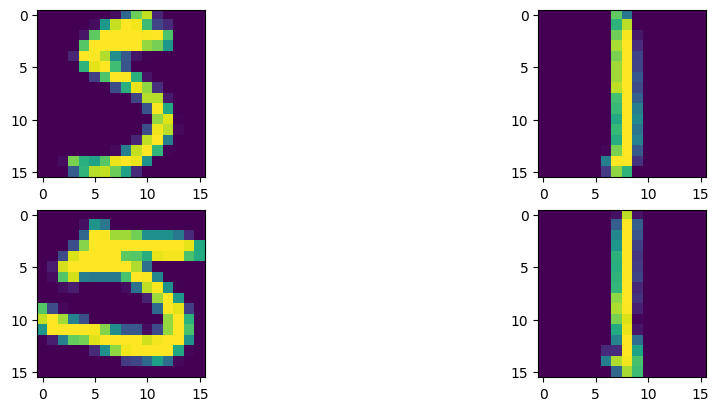

In [39]:
fig = plt.figure(layout='constrained', figsize=(10, 4))

fig.add_subplot(2,2,1)

plt.imshow( train_images[-1].reshape(16,16))
fig.add_subplot(2,2,2)
plt.imshow( train_images[0].reshape(16,16))
fig.add_subplot(2,2,3)

plt.imshow( train_images[-2].reshape(16,16))
fig.add_subplot(2,2,4)
plt.imshow( train_images[1].reshape(16,16))
plt.show()

## Part A

### Extracting Symetry

To extract the symetry feature of an image, choosing a symetry axis is required. This case, horizontal line between 8th and 9th rows in the image matrix is used.

For 16x16 matrice $x$, smymetry function is calculated as:

$
symmetry(x) = \sum_{r = 0}^{7}\sum_{c = 0}^{15} (x_{(r,c)} - x_{(r+8,c)})^2
$

where $x_{(r,c)}$ indicates the pixel value at row $r$ and column $c$

In [40]:
symmetry_train = ((train_images[:,:8] - train_images[:,8:])**2).sum(axis = -1).sum(axis = -1) 
symmetry_test = ((test_images[:,:8] - test_images[:,8:])**2).sum(axis = -1).sum(axis = -1) 

#### Extracting Intensity

Intensity of a image is defined as mean value of all pixels in the image.

In [41]:
intensity_train = ((train_images )).mean(axis=-1).mean(axis = -1)
intensity_test = ((test_images )).mean(axis=-1).mean(axis = -1)

## Part B

To see how well these values classify an image, a scatter plot will be useful:

In [42]:
labels = []
for label in train_labels:
    if label == 1:
        labels.append("1")
    else:
        labels.append("5")
fig = px.scatter(x=symmetry_train, y=intensity_train, color = labels, symbol= labels, labels={"x" :"symmetry", "y" : "intensity"}, title = "Intensity and Symmetry distribution over training data")
fig.show()

As can be seen, symmetry and intensity features can be used to map the image data to a latent space where classes are linearly seperable with an acceptable accuracy in our training data.

In [43]:
t_labels = []
for label in test_labels:
    if label == 1:
        t_labels.append("1")
    else:
        t_labels.append("5")
fig = px.scatter(x=symmetry_test, y=intensity_test, color = t_labels, symbol= t_labels, labels={"x" :"symmetry", "y" : "intensity"}, title = "Intensity and Symmetry distribution over test data")
fig.show()

## Part C

Gradient of the logistic loss over a set of samples:

$
E(x) =\frac{1}{N} \sum_{n = 0}^{N}ln(1 + exp(-yw^Tx))
$

$
\frac{\partial E(x)}{\partial w} =\frac{\partial}{\partial w}\frac{1}{N} \sum_{n = 0}^{N}ln(1 + exp(-yw^Tx))
$


$
\frac{\partial E(x)}{\partial w} =\frac{1}{N} \frac{\partial}{\partial w} \sum_{n = 0}^{N}ln(1 + exp(-yw^Tx))
$

$
\frac{\partial E(x)}{\partial w} =\frac{1}{N} \sum_{n = 0}^{N} \frac{\partial}{\partial w} ln(1 + exp(-yw^Tx))
$

$
\frac{\partial E(x)}{\partial w} =\frac{1}{N} \sum_{n = 0}^{N} \frac{1}{1 + exp(-yw^Tx)}\frac{\partial}{\partial w} (1 + exp(-yw^Tx))
$

$
\frac{\partial E(x)}{\partial w} =\frac{1}{N} \sum_{n = 0}^{N} \frac{exp(-yw^Tx)}{1 + exp(-yw^Tx)}\frac{\partial}{\partial w} (-yw^Tx)
$

$
\frac{\partial E(x)}{\partial w} =\frac{1}{N} \sum_{n = 0}^{N} \frac{exp(-yw^Tx)}{1 + exp(-yw^Tx)} (-yx)
$

implementing logistic loss and its gradients:

In [44]:
def gradient_loss(w , data, labels):
    label_data = -1 * labels.reshape((data.shape[0], 1)) * data # -yX
    ywt =  (label_data * w).sum(axis = 1) # -ywTx
    exp_ywt = np.exp(ywt) # exp(-ywTx)
    exp_ywt_p1 = exp_ywt + 1 # exp(-ywTx) + 1 
    ln = np.log(exp_ywt_p1)# ln(exp(-ywTx) + 1 )
    logistic_loss = ln.sum() / data.shape[0]
    gradient = ((exp_ywt / exp_ywt_p1).reshape((label_data.shape[0], 1)) * label_data).sum(axis=0) / data.shape[0]
    return logistic_loss, gradient

Using this function to implement gradient descent:

In [48]:
def train(epochs, lr):
    w = np.random.rand(test_data.shape[1])
    for i in range(epochs +1):
        loss, gradient = gradient_loss(w, train_data, train_labels)
        w = w - gradient * lr
        if i %100 == 0:
            preds = 1/np.exp(1 +  -(test_data * w).sum(axis = 1)) > 0.5 
            acc = np.count_nonzero(preds.astype(np.int8) == test_labels) / test_labels.shape[0]
            print(f"epoch:{i} , loss: {loss}, test accuracy: {(acc *100):.2f}%")

Firstly, since we will be using sigmoid outputs, we need to convert our labels to 0 and 1 type, since train_labels are only used for logistic loss calculation, they are emited from this step, because logistic loss works better with -1 and 1 labels, since 0 labels result in a 0 gradient.

In [45]:
test_labels = (test_labels== 1).astype(np.int8)

Now, training the model:

In [49]:
train(1000, 0.01)

epoch:0 , loss: 62.422690366603256, test accuracy: 37.03%
epoch:100 , loss: 0.8226799002202326, test accuracy: 81.60%
epoch:200 , loss: 0.3358021285942568, test accuracy: 88.21%
epoch:300 , loss: 0.2142356792290066, test accuracy: 91.98%
epoch:400 , loss: 0.15250905362696124, test accuracy: 93.63%
epoch:500 , loss: 0.11582608853864693, test accuracy: 94.58%
epoch:600 , loss: 0.09229012839214157, test accuracy: 94.58%
epoch:700 , loss: 0.0761726754474727, test accuracy: 94.81%
epoch:800 , loss: 0.06458078621424355, test accuracy: 95.52%
epoch:900 , loss: 0.05591917638796071, test accuracy: 95.52%
epoch:1000 , loss: 0.04926472835839067, test accuracy: 95.75%


Now to prove our previous statement about train_labels, lets map train labels to {0,1} set and perform the same training.

In [50]:
train_labels = (train_labels== 1).astype(np.int8)
train(1000, 0.01)

epoch:0 , loss: 58.395763816727445, test accuracy: 37.03%
epoch:100 , loss: 0.5804852499924683, test accuracy: 79.25%
epoch:200 , loss: 0.30324429247170864, test accuracy: 79.25%
epoch:300 , loss: 0.2743653766927727, test accuracy: 78.54%
epoch:400 , loss: 0.2633064903890156, test accuracy: 77.59%
epoch:500 , loss: 0.25779558462813046, test accuracy: 77.59%
epoch:600 , loss: 0.2546482501674912, test accuracy: 76.65%
epoch:700 , loss: 0.2526822270760455, test accuracy: 76.65%
epoch:800 , loss: 0.2513717288732508, test accuracy: 76.65%
epoch:900 , loss: 0.25045548994875305, test accuracy: 76.42%
epoch:1000 , loss: 0.24979166977319653, test accuracy: 76.42%


As can be seen, accuracy suffered from not getting variable gradients from the 0 samples.